# Plot Downsampling for Ust Ishim
(with replicates)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from matplotlib import gridspec

##############################
import socket
import os as os
import sys as sys
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./package/hapsburg/PackagesSupport/")
from pp_individual_roh_csvs import create_combined_ROH_df

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [87]:
def add_bins(df, cms=[4,8,12,20]):
    """Add bins with sums to dataframe
    return new dataframe"""
    for i in range(len(cms)-1):
        cm1, cm2 = cms[i], cms[i+1]
        label = str(cm1) + "-" + str(cm2)
        df[label] = df[f"sum_roh>{cm1}"] - df[f"sum_roh>{cm2}"]
    return df

def load_dip_df(paths = ["./Empirical/Eigenstrat/Reichall/diploid/Ust_Ishim_published.DG_roh_full.csv"],
                iids=np.array(["UstIshim_snpAD.DG"]),cms = [4, 8, 12, 20]):
    """Load diploid Genotype dataframe"""
    df_dip = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, 
                                         gap=0.5, min_len1=2, min_len2=4, output=False)

    hline_vec = np.array([df_dip[f"sum_roh>{cm}"].values[0] for cm in cms])
    return df_dip, hline_vec


### To get the RC Groundtruth data
def prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour/", iid = "Loschbour",
                   suffix = "_roh_full.csv", down_sampling_covs=np.geomspace(0.01, 1.0, 10), cms = [4, 8, 12],
                   gap = 0.5, min_len1=2.0, min_len2=4.0, tot_cov=19.5486, prefix=""):
    """Prepare Dataframe of results -> Combine Individual results into one dataframe"""
    samples = np.array([prefix + f"{c:.4f}" for c in down_sampling_covs])   # Numpy Array for better slicing
    paths = [os.path.join(base_path, s[:10] + suffix) for s in samples]
    df_t = create_combined_ROH_df(paths, samples, pops=samples, min_cm=cms, snp_cm=50, 
                                  gap=gap, min_len1=min_len1, min_len2=min_len2,
                                  output=False, sort=False)
    df_t["mean_cov"] = down_sampling_covs * tot_cov   #* 10.439 for IPK12
    return df_t

def plot_downsampling_rep(df, figsize=(5,5), columns = ["4-8", "8-12", "12-20"],
                          colors=['#313695', '#abd9e9', '#fee090', '#d7191c'],
                          xlabel="Number 1240k SNPs covered [Ust Ishim, 45k BP]",
                          ms=7, fs_l=12, fs_t=10, ylim=[0,75], leg_loc="upper left", 
                          hline_vec=[], cutoff=0.25, savepath=""):
    """Plot Downsampling with replicates"""
    plt.figure(figsize=figsize)
    ax = plt.gca()
    x = df["n_snps"]

    for i in range(len(columns)):
        col, c = columns[i], colors[i]
        y=df[col]["mean"]
        std=df[col]["std"]
        ax.plot(x,y, "o--", c=c, ms=ms, label=col+"cM",zorder=1)
        ax.errorbar(x, y, yerr=std, zorder=0, c=c)

    ax.set_xlabel(xlabel, fontsize=fs_l)
    ax.set_ylabel("Genome-wide sROH [cm]", fontsize=fs_l)
    ax.tick_params(axis='both', labelsize=fs_t)
    
    if len(leg_loc)>0:
        ax.legend(loc=leg_loc, title="sROH")
        
    if len(ylim)>0:
        ax.set_ylim(ylim)

    if cutoff>0:
        ax.axvline(cutoff, c="gray")


    for y in hline_vec:
        ax.axhline(y, lw=1, zorder=0, c="gray")
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved Figure to: {savepath}")
    plt.show()

# Plot Ust Ishim Replicates

In [84]:
### Load the Diploid Data
df_dip, hline_vec = load_dip_df()
hline_vec = hline_vec[:-1]-hline_vec[1:]

In [85]:
df = pd.read_csv("./Empirical/1240k/SA_Readcounts/Ust_Ishim_rep/combined_roh05.tsv", sep='\t')
df = add_bins(df)
df[">20"]=df["sum_roh>20"]
df1 = df[["iid", "pop", "4-8", "8-12", "12-20", ">20"]].copy()
df_res = df1.groupby("pop").agg(["mean", "std"])
df_res["n_snps"] = df_res.index.values * 1115315 # Ust Ishim Covered

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/down_ust_rep_v2.pdf


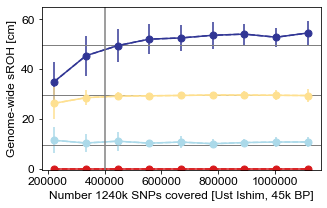

In [90]:
plot_downsampling_rep(df = df_res, figsize=(5,3), columns = ["4-8", "8-12", "12-20", ">20"],
                      colors=['#313695', '#abd9e9', '#fee090', '#d7191c'],
                      ms=7, fs_l=12, fs_t=12, ylim=[-0.5,65], leg_loc="",
                      hline_vec=hline_vec, cutoff=4e5,
                      savepath="./figures/manuscript/supplement/downsampling_sa/down_ust_rep_v2.pdf"
                      )

### Plot IPk12 [South America, 600 BP, 10x, 1,114,250 markers covered] 

In [28]:
### Load Readcount Data (for ground truth)
#df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", iid = "IPK12",
#                       suffix = "_roh_full.csv", down_sampling_covs = np.geomspace(0.04, 1.0, 10), cms = [4, 8, 12, 20],
#                       gap = 0.5, min_len1=2, min_len2=4, tot_cov=10.438989, prefix="IPK12")

In [81]:
### Load the Diploid Data
#df_dip, hline_vec = load_dip_df()
#df_rc
#hline_vec = np.array([346.84,226.7,165.79,	48.69]) # The 0.9 values
#hline_vec1 = hline_vec[:-1]-hline_vec[1:]
hline_vec1 = df_res.iloc[-1][["4-8", "8-12", "12-20", ">20"]]
hline_vec1 = [x for x in hline_vec1][0::2]

In [47]:
df = pd.read_csv("./Empirical/1240k/SA_Readcounts/IPK12_rep/combined_roh05.tsv", sep='\t')
df = add_bins(df)
df[">20"]=df["sum_roh>20"]
df1 = df[["iid", "pop", "4-8", "8-12", "12-20", ">20"]].copy()
df_res = df1.groupby("pop").agg(["mean", "std"])
df_res["n_snps"] = df_res.index.values * 1115315 # Ust Ishim Covered

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/IPK12_rep_v1.png


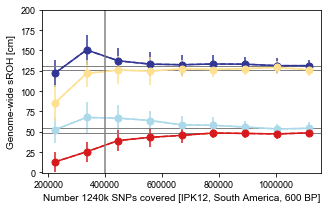

In [83]:
plot_downsampling_rep(df = df_res, figsize=(5,3), columns = ["4-8", "8-12", "12-20", ">20"],
                      colors=['#313695', '#abd9e9', '#fee090', '#d7191c'],
                      ms=7, fs_l=10, fs_t=9, ylim=[-0.5,200], leg_loc="",
                      hline_vec=hline_vec1,
                      cutoff=4e5, xlabel = "Number 1240k SNPs covered [IPK12, South America, 600 BP]",
                      savepath="./figures/manuscript/supplement/downsampling_sa/IPK12_rep_v1.png"
                      )